**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**October, 2023**

---

# Run limma differential expression analysis

In [7]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [8]:
anndata <- readRDS('../../../../data_integration/48h/results/scVI/toxoplasma_singleCell_48h.rds')
anndata

An object of class Seurat 
36601 features across 24479 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [9]:
Idents(anndata)= anndata$cell_type

In [10]:
head(Idents(anndata))

Pla_HDBR13007976_AAACCCAAGCCTCATA Pla_HDBR13007976_AAACCCAAGCTGTTAC 
                              HBC                        VCT_fusing 
Pla_HDBR13007976_AAACCCAAGGCATCAG Pla_HDBR13007976_AAACCCACACTAAACC 
                              HBC                        VCT_fusing 
Pla_HDBR13007976_AAACCCACACTACGGC Pla_HDBR13007976_AAACCCACAGCAGTCC 
                       VCT_fusing                        VCT_fusing 
14 Levels: EVT_1 EVT_2 Endo_f F F_p HBC HBC_p PAMM1 PV VCT ... iEVT

# Trophoblast

In [11]:
Troph= subset(x = anndata, idents = c("VCT_fusing","VCT"))

Idents(object = Troph) <- "infection"


#fixxing levels
Troph$celltype.Stage = factor(Troph$celltype.Stage, levels = c("VCT_fusing-Tg_48h", "VCT_fusing-UI_Tg_48h", "VCT-Tg_48h","VCT-UI_Tg_48h"))
Troph$cell_type<- factor(Troph$cell_type, levels = c("VCT_fusing", "VCT"))

#The levels for the infection should follow this order to ensure that positive Fold changes correspond to increases in infection
Troph$infection<- factor(Troph$infection, levels = c("UI","Tg"))

In [12]:
Troph$classification = paste(Troph$cell_type, Troph$infection, sep='-') # split celltype by disease status


# estimate % cells expressing a gene in each class
plot <- DotPlot(object = Troph, features = rownames(Troph), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

In [13]:
head(percent_mat)

,VCT_fusing-Tg,VCT_fusing-UI,VCT-Tg,VCT-UI
AC115284.3,0.0000000,0.0000000,0.0000000,0.0000000
RNF186,0.0000000,0.0000000,0.0000000,0.0000000
FMR1,82.8035860,85.3257790,90.2482270,90.9180652
CANX,98.6960065,99.6033994,99.1134752,99.4076999
ZNF84-DT,0.1629992,0.2832861,0.3546099,0.8884501
LIPA,10.9209454,10.7648725,41.6666667,44.0276407


In [14]:
#print(Idents(VCT_fusing))

In [15]:
table(Troph[["celltype.Stage"]] )


   VCT_fusing-Tg_48h VCT_fusing-UI_Tg_48h           VCT-Tg_48h 
                1227                 1765                  564 
       VCT-UI_Tg_48h 
                1013 

In [16]:
anndata_sce <- as.SingleCellExperiment(Troph)

In [17]:
anndata_sce

class: SingleCellExperiment 
dim: 36601 4569 
metadata(0):
assays(2): counts logcounts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(4569): Pla_HDBR13007976_AAACCCAAGCTGTTAC
  Pla_HDBR13007976_AAACCCACACTAAACC ...
  Pla_HDBR13798226_TTTGGTTGTAATCAGA Pla_HDBR13798226_TTTGTTGAGAGTAACT
colData names(11): infection donor_id ... classification ident
reducedDimNames(0):
altExpNames(0):

In [18]:
anndata_sce

class: SingleCellExperiment 
dim: 36601 4569 
metadata(0):
assays(2): counts logcounts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(4569): Pla_HDBR13007976_AAACCCAAGCTGTTAC
  Pla_HDBR13007976_AAACCCACACTAAACC ...
  Pla_HDBR13798226_TTTGGTTGTAATCAGA Pla_HDBR13798226_TTTGTTGAGAGTAACT
colData names(11): infection donor_id ... classification ident
reducedDimNames(0):
altExpNames(0):

### Prepare the pseudobulk count matrix:

In [19]:
# generate 3 metacells for each donor-celltype combination
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste( colData(anndata_sce)$infection, 
                                colData(anndata_sce)$cell_type, 
                                colData(anndata_sce)$donor_id, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')
## aggregateAcrossCells here it is only aggregated by celltype, genotype and random group
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]


#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$classification)
table(summed$infection)

,Tg-VCT_fusing-scDonor_Tg1-1,Tg-VCT_fusing-scDonor_Tg1-2,Tg-VCT_fusing-scDonor_Tg1-3,Tg-VCT_fusing-scDonor_Tg2-1,Tg-VCT_fusing-scDonor_Tg2-2,Tg-VCT_fusing-scDonor_Tg2-3,Tg-VCT_fusing-scDonor_Tg3-1,Tg-VCT_fusing-scDonor_Tg3-2,Tg-VCT_fusing-scDonor_Tg3-3,Tg-VCT_fusing-scDonor_Tg4-1,⋯,UI-VCT-scDonor_Tg1-3,UI-VCT-scDonor_Tg2-1,UI-VCT-scDonor_Tg2-2,UI-VCT-scDonor_Tg2-3,UI-VCT-scDonor_Tg3-1,UI-VCT-scDonor_Tg3-2,UI-VCT-scDonor_Tg3-3,UI-VCT-scDonor_Tg4-1,UI-VCT-scDonor_Tg4-2,UI-VCT-scDonor_Tg4-3
AC115284.3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
RNF186,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FMR1,378,417,375,93,165,67,445,492,613,437,⋯,597,183,235,186,183,118,164,380,444,383



VCT_fusing-Tg VCT_fusing-UI        VCT-Tg        VCT-UI 
           12            12            12            12 


UI Tg 
24 24 

In [20]:
summed

class: SingleCellExperiment 
dim: 36601 48 
metadata(0):
assays(1): counts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(48): Tg-VCT_fusing-scDonor_Tg1-1 Tg-VCT_fusing-scDonor_Tg1-2
  ... UI-VCT-scDonor_Tg4-2 UI-VCT-scDonor_Tg4-3
colData names(15): infection donor_id ... ids ncells
reducedDimNames(0):
altExpNames(0):

In [21]:
summed$infection<- factor(summed$infection, levels = c( "UI","Tg"))

In [22]:
table(summed$infection)


UI Tg 
24 24 

### Corrected by genotype

In [23]:
DEGs_list = list()

In [24]:
for (celltypeOf_interest in unique(summed$cell_type) ){
    
    #celltypeOf_interest = 'VCT'
    print(celltypeOf_interest)

    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$cell_type == celltypeOf_interest)


    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
    #     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$donor_id, min.prop = 0.2)

    genes20percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) > 20 ] # get genes with > 20% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes20percent
    y <- y[ keep ,]



    # (2) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    y <- edgeR::calcNormFactors(y)


    ##see how many genes were kept 
    summary(keep)


    # (3) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    ## Create the design matrix for paired samples while correcting for the effect of the donor to obtain
    #  the overall effect of the infection across donors:
    design <- model.matrix(~summed_celltype$donor_id+summed_celltype$infection)
        # stimate dispersion
    y <- estimateDisp(y,design)
        # Have a look
    head(design)


    # (4) Do limma DEG
    fit <- glmQLFit(y, design)
    qlf <- glmQLFTest(fit)
    topTags(qlf)

    ##  Adjust P values using bonferroni and BH
    limma_de = qlf$table
    limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
    limma_de$p_val_adj = p.adjust(limma_de$PValue, "BH")
    
    # order table by P-value
    limma_de= limma_de[ order(limma_de$p_val_adj, decreasing = FALSE), ]
    #limma_de <- order(limma_de$p.adjust, decreasing = FALSE)
    #imma_de = limma_de.sort_values('p.adjust', ascending = TRUE)

    # Adding to the list
    DEGs_list[[celltypeOf_interest]] = limma_de
} 

[1] "VCT_fusing"
[1] "VCT"


In [25]:
##  Saving the DEG matrix

write.table(DEGs_list[["VCT_fusing"]],'../results/SC_limma_Trophoblast_TOX_48h/1_DEGs_SC_TOX_48h_VCT_fusing.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["VCT"]],'../results/SC_limma_Trophoblast_TOX_48h/2_DEGs_SC_TOX_48h_VCT.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)


In [26]:
#limma_de= DEGs_list[["VCT"]]

In [27]:
#colData(summed_celltype)$metacell_id

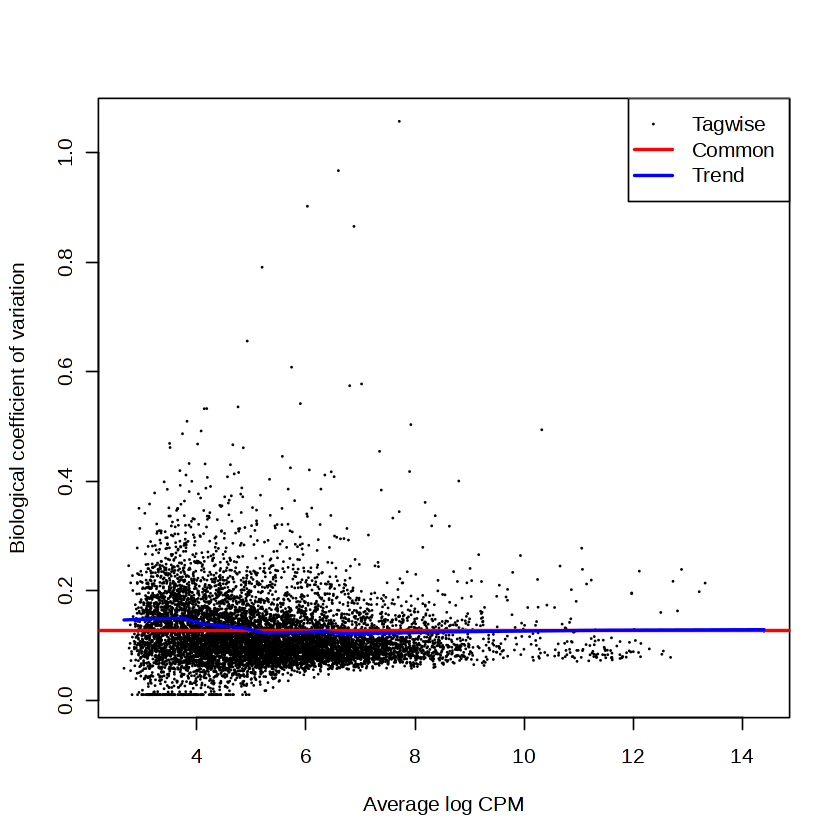

In [28]:
plotBCV(y)

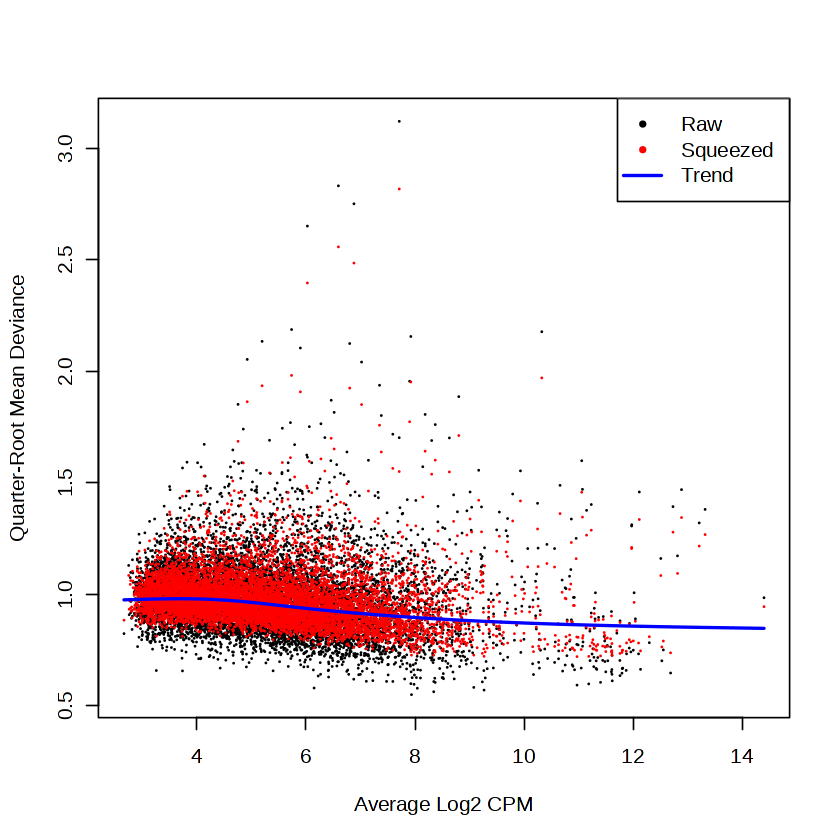

In [29]:
plotQLDisp(fit)

In [30]:
o <- order(qlf$table$PValue)
cpm(y)[o[1:20],]

,Tg-VCT-scDonor_Tg1-1,Tg-VCT-scDonor_Tg1-2,Tg-VCT-scDonor_Tg1-3,Tg-VCT-scDonor_Tg2-1,Tg-VCT-scDonor_Tg2-2,Tg-VCT-scDonor_Tg2-3,Tg-VCT-scDonor_Tg3-1,Tg-VCT-scDonor_Tg3-2,Tg-VCT-scDonor_Tg3-3,Tg-VCT-scDonor_Tg4-1,⋯,UI-VCT-scDonor_Tg1-3,UI-VCT-scDonor_Tg2-1,UI-VCT-scDonor_Tg2-2,UI-VCT-scDonor_Tg2-3,UI-VCT-scDonor_Tg3-1,UI-VCT-scDonor_Tg3-2,UI-VCT-scDonor_Tg3-3,UI-VCT-scDonor_Tg4-1,UI-VCT-scDonor_Tg4-2,UI-VCT-scDonor_Tg4-3
COPB1,161.884365,170.317978,163.11006,183.493752,205.159405,145.920752,153.82930,148.676342,164.8700573,183.680157,⋯,108.77979,132.4544788,135.3052313,129.2137958,108.539539,106.73518,109.6403902,145.685154,164.180700,146.731116
ARL14EPL,35.904314,34.606442,45.33907,45.007901,32.902923,45.397567,23.72134,25.523836,21.9826743,20.676039,⋯,22.68394,16.2189158,20.5007926,26.8718956,17.986552,19.54306,20.5209286,14.038184,12.754534,14.581974
MINDY2,80.627232,85.498268,103.39519,86.553656,112.257033,96.199607,99.91717,102.095342,111.1346312,138.481375,⋯,53.61658,70.9577565,87.6408884,64.6068979,73.806887,82.68218,90.2920860,89.220458,84.939767,85.061517
RTTN,39.053816,35.284999,35.93951,30.005268,30.967457,42.154884,25.87783,27.438123,28.0889727,30.773639,⋯,22.85579,22.9767973,24.6009511,26.8718956,14.885423,14.28147,18.7619919,24.956772,28.494171,29.467740
NBEAL1,190.229876,206.960093,188.54418,173.107313,172.256481,161.053274,242.96404,305.647931,232.0393399,307.736389,⋯,130.26079,145.9702419,162.4687815,138.9334176,205.294786,206.70545,160.0632434,239.273047,253.733809,221.767525
HSPA1A,42.203317,46.820480,34.83367,40.391706,63.870381,43.235778,64.69457,42.114329,58.0098350,7.693410,⋯,75.78497,64.1998749,60.4773382,58.8894733,89.312535,88.69543,72.1164064,38.059077,19.810233,18.531259
AC211433.1,69.289028,117.390479,192.96750,66.934828,106.450635,20.536995,132.98328,109.114397,137.3917144,124.537070,⋯,67.70812,25.6799500,29.2136295,21.7262135,41.555138,11.27484,27.5566756,93.275934,111.262954,61.669600
FCHSD2,230.543492,227.995381,258.76444,255.044774,267.094319,248.605725,284.65610,327.343191,327.2975952,259.171740,⋯,207.59239,201.3848708,184.5071336,180.0988747,243.128568,238.27501,220.4534048,247.383998,211.670985,197.464235
NRCAM,36.534215,51.570384,24.88120,19.618829,21.290127,32.426834,49.59917,33.819082,43.9653486,54.815544,⋯,43.47755,50.6841118,38.9515060,29.7306079,78.768694,63.13912,69.1848451,87.348700,84.939767,86.884263
SHOC1,21.416609,17.642500,23.77537,19.618829,34.838389,12.970734,15.09540,18.504781,20.1507848,14.905981,⋯,10.13903,10.8126105,8.7128369,14.8653039,9.303389,9.77153,12.8988694,8.422910,13.025907,9.721316


In [31]:
summary(decideTests(qlf))

       summed_celltype$infectionTg
Down                            66
NotSig                        9126
Up                             149

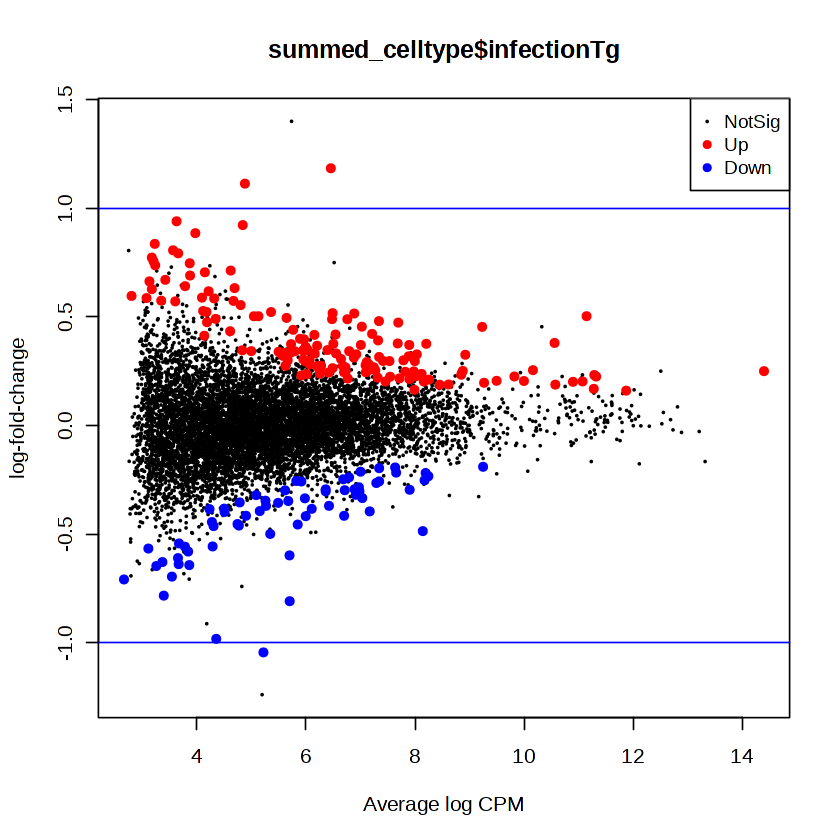

In [32]:
plotMD(qlf)
abline(h=c(-1, 1), col="blue")

In [33]:
hist(limma_de$BH)

ERROR: Error in hist.default(limma_de$BH): 'x' must be numeric


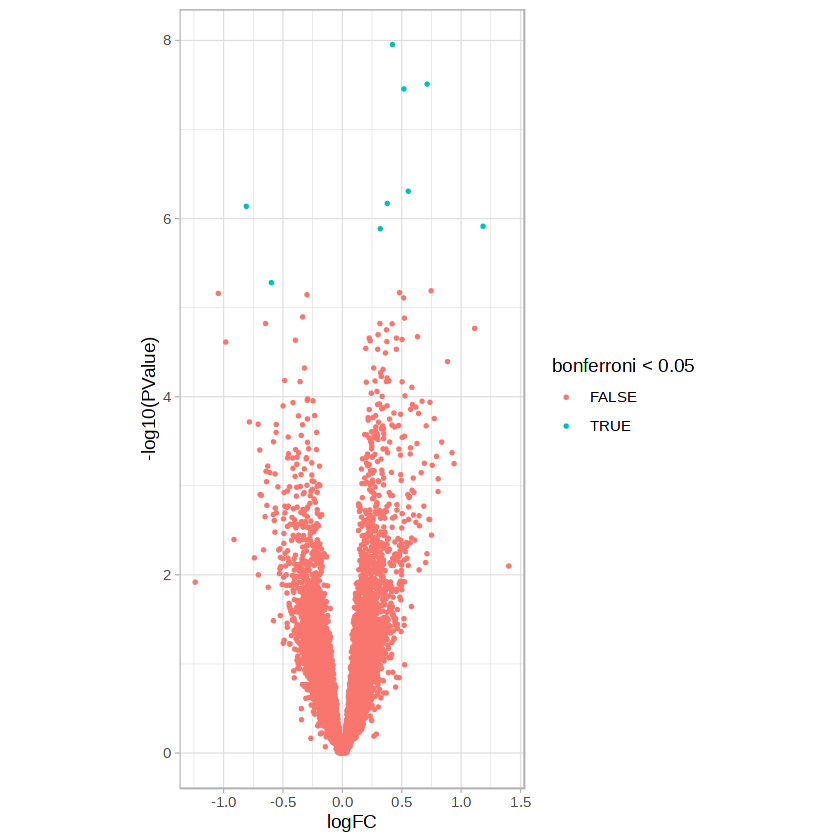

In [34]:
library(ggplot2, warn.conflicts = FALSE)
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = bonferroni < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

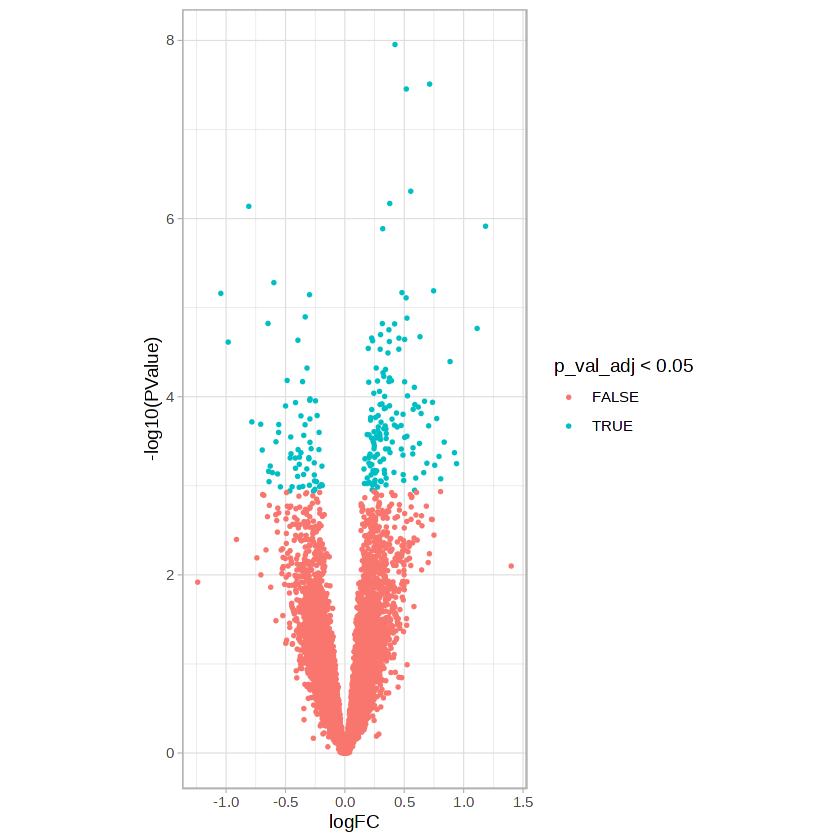

In [35]:
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = p_val_adj < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)